# Import libraries and load data

In [1]:
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from wordcloud import WordCloud

In [2]:
#df = pd.read_csv("../src/article_scraping/data/articles_with_text.csv")
df = pd.read_csv("articles_with_text.csv")

# **Clean Text**

In [3]:
def clean_text(text, lowercase=True, remove_punctuation=True):
    if lowercase:
        text = text.lower()
    if remove_punctuation:
        text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['article_text_raw'].apply(clean_text)


# **Load Sentiment Models and Analyze Sentiments**

In [4]:
pipe1 = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", truncation=True)
pipe2 = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment", truncation=True)

# **Analyze Sentiments**
def analyze_sentiments(text):
    try:
        roberta_result = pipe1(text[:512])[0]
        bert_result = pipe2(text[:512])[0]

        # Normalize nlptown's star ratings to sentiment
        bert_sentiment = {
            "1 star": "negative",
            "2 stars": "negative",
            "3 stars": "neutral",
            "4 stars": "positive",
            "5 stars": "positive"
        }.get(bert_result['label'], "unknown")

        return roberta_result['label'], roberta_result['score'], bert_sentiment, bert_result['score']
    except Exception as e:
        return "error", 0, "error", 0

# Apply sentiment analysis to the dataset
df[['roberta_label', 'roberta_score', 'bert_label', 'bert_score']] = df['cleaned_text'].apply(analyze_sentiments).apply(pd.Series)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [5]:
# **Save Results**
df.to_csv("articles_with_sentiments.csv", index=False)

# **Visualizations**

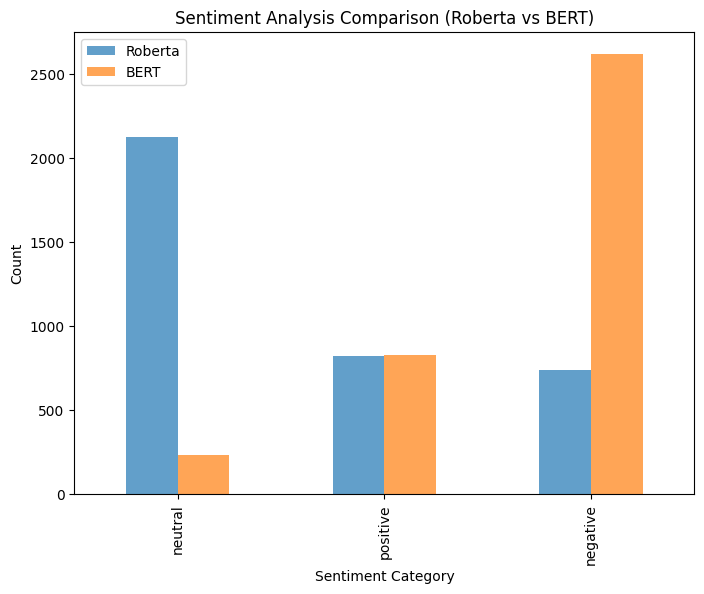

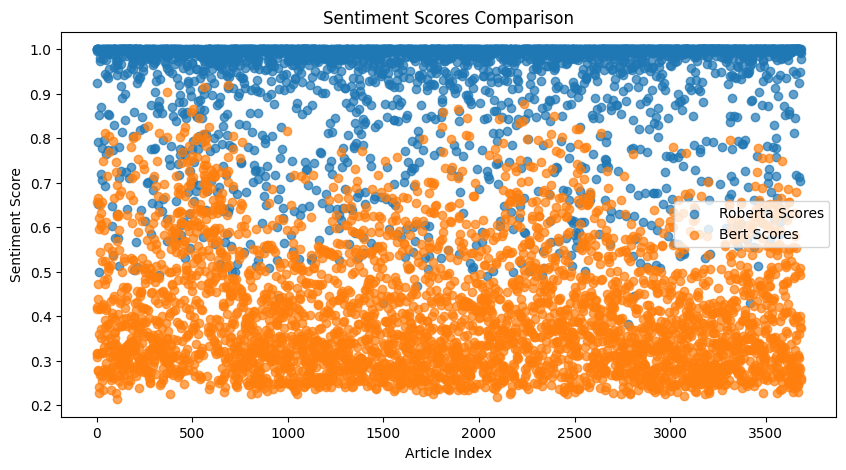

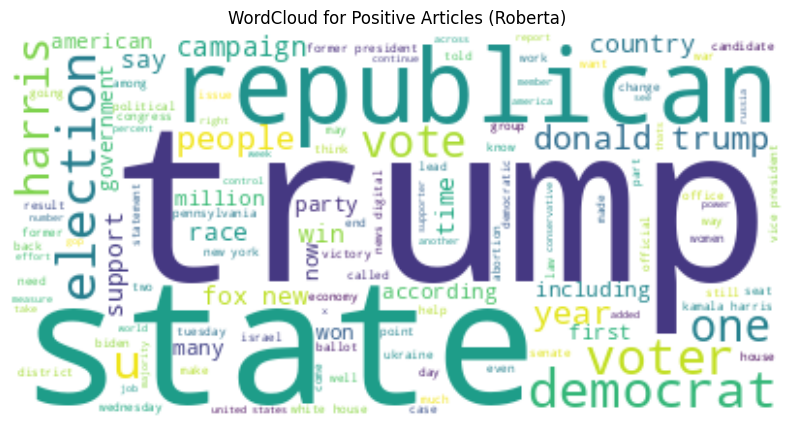

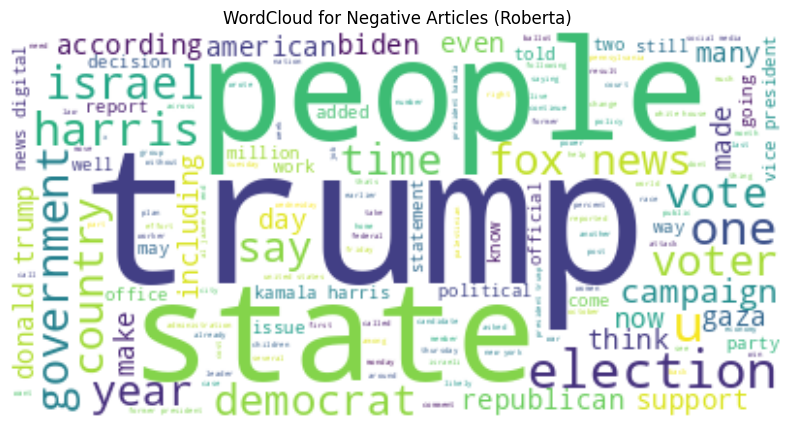

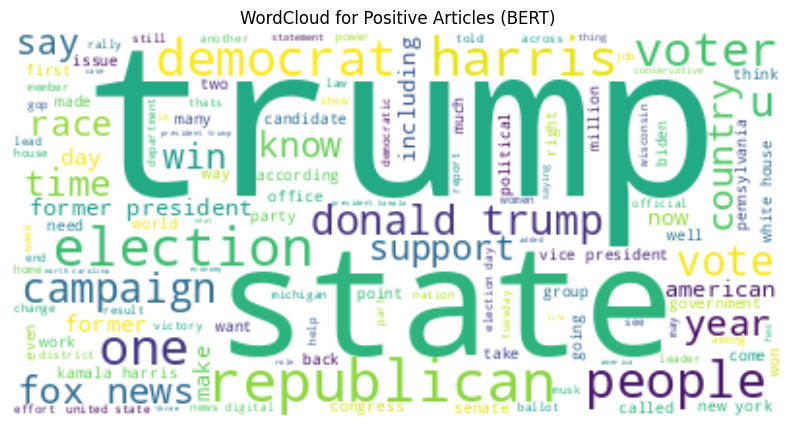

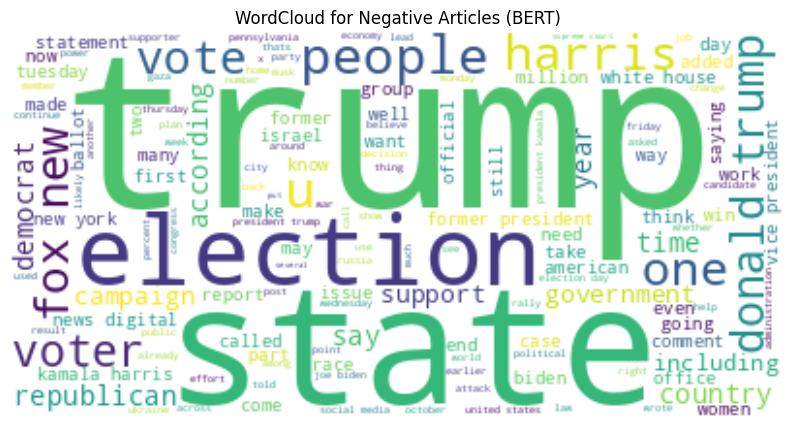

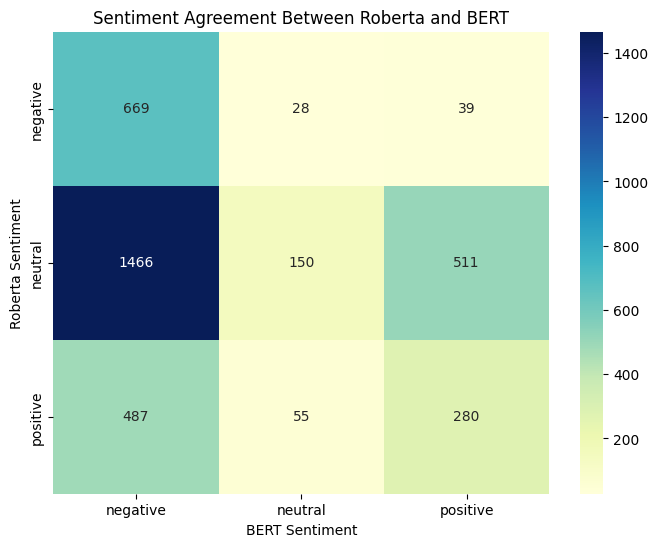

In [15]:
# Bar Chart: Frequency of Sentiments
sentiment_counts = pd.DataFrame({
    "Sentiment": df['roberta_label'].value_counts().index,
    "Roberta": df['roberta_label'].value_counts().values,
    "BERT": df['bert_label'].value_counts().reindex(df['roberta_label'].value_counts().index, fill_value=0).values
})

sentiment_counts.plot(kind="bar", x="Sentiment", figsize=(8, 6), alpha=0.7, title="Sentiment Analysis Comparison (Roberta vs BERT)")
plt.ylabel("Count")
plt.xlabel("Sentiment Category")
plt.show()

# Scatter Plot: Sentiment Scores Comparison
plt.figure(figsize=(10, 5))
plt.scatter(df.index, df['roberta_score'], label="Roberta Scores", alpha=0.7)
plt.scatter(df.index, df['bert_score'], label="Bert Scores", alpha=0.7)
plt.title("Sentiment Scores Comparison")
plt.xlabel("Article Index")
plt.ylabel("Sentiment Score")
plt.legend()
plt.show()

from wordcloud import STOPWORDS
custom_stopwords = set(STOPWORDS).union({"said", "will"})


# WordCloud for Articles with Positive Sentiments (Roberta)
positive_text = " ".join(df[df['roberta_label'] == "positive"]['cleaned_text'])
wordcloud = WordCloud(background_color="white", max_words=200, stopwords=custom_stopwords).generate(positive_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud for Positive Articles (Roberta)")
plt.show()

# WordCloud for Articles with Negative Sentiments (Roberta)
negative_text = " ".join(df[df['roberta_label'] == "negative"]['cleaned_text'])
wordcloud = WordCloud(background_color="white", max_words=200, stopwords=custom_stopwords).generate(negative_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud for Negative Articles (Roberta)")
plt.show()

# WordCloud for Positive Articles (BERT)
positive_text_bert = " ".join(df[df["bert_label"] == "positive"]["cleaned_text"])
wordcloud_positive_bert = WordCloud(
    background_color="white",
    max_words=200,
    stopwords=custom_stopwords
).generate(positive_text_bert)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_positive_bert, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud for Positive Articles (BERT)")
plt.show()

# WordCloud for Negative Articles (BERT)
negative_text_bert = " ".join(df[df["bert_label"] == "negative"]["cleaned_text"])
wordcloud_negative_bert = WordCloud(
    background_color="white",
    max_words=200,
    stopwords=custom_stopwords
).generate(negative_text_bert)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_negative_bert, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud for Negative Articles (BERT)")
plt.show()


# Heatmap for Sentiment Agreement
sentiment_matrix = pd.crosstab(df['roberta_label'], df['bert_label'])
plt.figure(figsize=(8, 6))
sns.heatmap(sentiment_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Sentiment Agreement Between Roberta and BERT")
plt.ylabel("Roberta Sentiment")
plt.xlabel("BERT Sentiment")
plt.show()
